In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score
import time
import os
import matplotlib.pyplot as plt

# Load datasets
train_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/train.tsv"
test_url = "https://raw.githubusercontent.com/clairett/pytorch-sentiment-classification/master/data/SST2/test.tsv"

train_df = pd.read_csv(train_url, sep='\t', names=['sentence', 'label'], header=None)
test_df = pd.read_csv(test_url, sep='\t', names=['sentence'], header=None)


# Display the first few rows to verify
print("Train Data:\n", train_df.head())
print("\nTest Data:\n", test_df.head())

# Split into training and validation sets (80/20)
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

print(f"\nTraining set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")


Train Data:
   a stirring , funny and finally transporting re imagining of beauty and the beast and 1930s horror films  \
0  apparently reassembled from the cutting room f...                                                        
1  they presume their audience wo n't sit still f...                                                        
2  this is a visually stunning rumination on love...                                                        
3  jonathan parker 's bartleby should have been t...                                                        
4  campanella gets the tone just right funny in t...                                                        

   1  
0  0  
1  0  
2  1  
3  1  
4  1  

Test Data:
         no movement , no yuks , not much of anything  0
0  a gob of drivel so sickly sweet , even the eag...  0
1  gangs of new york is an unapologetic mess , wh...  0
2  we never really feel involved with the story ,...  0
3              this is one of polanski 's best films 

In [ ]:

vectorizer.fit(train_data['a stirring '])
vectorizer.fit(train_data['sentence'])

vectorizer.fit(val_data['a stirring '])
vectorizer.fit(val_data['sentence'])

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size=10000, hidden_sizes=[512, 256, 128, 64], output_size=2, dropout_rate=0.3):
        super(MLP, self).__init__()

        layers = []
        in_size = input_size

        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_size = h

        layers.append(nn.Linear(in_size, output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)

# Create model instance
mlp_model = MLP()

# Count trainable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total Trainable Parameters: {count_parameters(mlp_model):,}")


Total Trainable Parameters: 5,293,122


In [ ]:
# Training function

def train_model(model, device):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    train_losses = []  # Store training losses
    val_accuracies = []  # Store validation accuracies

    for epoch in range(10):
        model.train()
        epoch_loss = 0  # Accumulate loss for the epoch

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()  # Add batch loss to epoch loss

        train_losses.append(epoch_loss / len(train_loader))  # Average epoch loss

        # Evaluate on validation set
        val_acc, _ = evaluate_model(model, device)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch + 1}/10], Loss: {train_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%")

    torch.save(model.state_dict(), "checkpoint.pt")
    return model, train_losses, val_accuracies

In [ ]:
#Evaluation function
def evaluate_model(model, device, half=False):
    model.eval()
    correct, total = 0, 0
    all_inputs, all_labels = [], []
    start = time.time()
    with torch.no_grad():
        for inputs, labels in val_loader:
            if half:
                inputs = inputs.half()
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    end = time.time()
    acc = correct / total * 100
    infer_time = (end - start) * 1000  # ms
    return acc, infer_time



In [ ]:
class TextDataset(Dataset): # Define a custom Dataset class for text data
    def __init__(self, data, vectorizer):
        self.data = data
        self.vectorizer = vectorizer

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data.iloc[idx, 0]
        label = self.data.iloc[idx, 1]
        text_vector = self.vectorizer.transform([text]).toarray()
        return torch.tensor(text_vector, dtype=torch.float32).squeeze(0), torch.tensor(label, dtype=torch.long)

vectorizer = CountVectorizer(max_features=10000)
vectorizer.fit(train_data['a stirring '])
val_dataset = TextDataset(val_data, vectorizer)

train_dataset = TextDataset(train_data, vectorizer)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:

# Storage size
def get_model_size(path="model.pt"):
    return os.path.getsize(path) / (1024 * 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch [1/10], Loss: 0.5879, Val Acc: 78.90%
Epoch [2/10], Loss: 0.2550, Val Acc: 77.46%
Epoch [3/10], Loss: 0.0701, Val Acc: 76.66%
Epoch [4/10], Loss: 0.0129, Val Acc: 76.08%
Epoch [5/10], Loss: 0.0058, Val Acc: 76.23%
Epoch [6/10], Loss: 0.0058, Val Acc: 76.01%
Epoch [7/10], Loss: 0.0093, Val Acc: 74.78%
Epoch [8/10], Loss: 0.0076, Val Acc: 76.45%
Epoch [9/10], Loss: 0.0099, Val Acc: 76.37%
Epoch [10/10], Loss: 0.0046, Val Acc: 76.23%
Epoch [1/10], Loss: 0.0004, Val Acc: 76.30%
Epoch [2/10], Loss: 0.0099, Val Acc: 76.37%
Epoch [3/10], Loss: 0.0325, Val Acc: 76.30%
Epoch [4/10], Loss: 0.0382, Val Acc: 77.82%
Epoch [5/10], Loss: 0.0078, Val Acc: 77.82%
Epoch [6/10], Loss: 0.0007, Val Acc: 76.73%
Epoch [7/10], Loss: 0.0006, Val Acc: 76.08%
Epoch [8/10], Loss: 0.0001, Val Acc: 77.31%
Epoch [9/10], Loss: 0.0001, Val Acc: 77.60%
Epoch [10/10], Loss: 0.0001, Val Acc: 77.24%


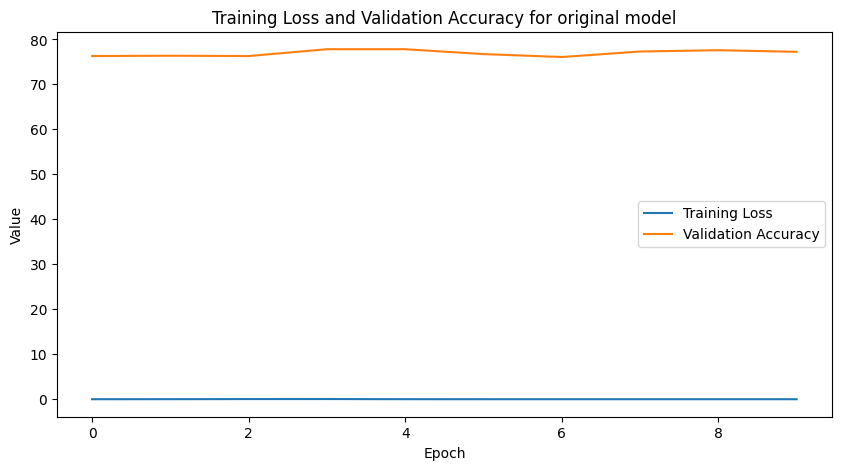

In [ ]:
# 1. Original Model
original_model = MLP()
original_model, train_losses, val_accuracies = train_model(original_model, device) # train_model returns a tuple (model, losses, accuracies)
original_model.load_state_dict(torch.load("checkpoint.pt")) # Now original_model refers to the actual model instance
torch.save(original_model.state_dict(), "original.pt")
orig_acc, orig_time = evaluate_model(original_model, device)
orig_size = get_model_size("original.pt")

# After training:
original_model, train_losses, val_accuracies = train_model(original_model, device)

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.title("Training Loss and Validation Accuracy for original model")
plt.legend()
plt.show()

In [ ]:
# 2. Dynamic (qint 8)
model_fp32 = MLP()
model_fp32.load_state_dict(torch.load("checkpoint.pt"))
model_fp32.eval()

quant_model = torch.quantization.quantize_dynamic(
    model_fp32, {nn.Linear}, dtype=torch.qint8
)

quant_acc, quant_time = evaluate_model(quant_model, device)

torch.save(quant_model.state_dict(), "quant_model.pt")
quant_size = os.path.getsize("quant_model.pt") / (1024 * 1024)



quant_acc_after_quant, quant_time_after_quant = evaluate_model(quant_model, device)
quant_size_after_quant = os.path.getsize("quant_model.pt") / (1024 * 1024)

In [ ]:

# 3. Half-Precision
half_model = MLP().to(device)
half_model.load_state_dict(torch.load("checkpoint.pt"))
half_model = half_model.half()
torch.save(half_model.state_dict(), "half.pt")
half_acc, half_time = evaluate_model(half_model, device, half=True)
half_size = get_model_size("half.pt")


In [ ]:
# Final comparison table
print("\nFinal Comparison Table:")
print(f"{'S.I.':<4} {'Model Name':<15} {'Accuracy (Out of 100)':<25} {'Storage (In MB)':<20} {'Inference time (In ms)':<25}")
print(f"{'1.':<4} {'Original':<15} {orig_acc:<25.2f} {orig_size:<20.2f} {orig_time:<25.2f}")
print(f"{'2.':<4} {'Dynamic':<15} {quant_acc:<25.2f} {quant_size:<20.2f} {quant_time:<25.2f}")
print(f"{'3.':<4} {'Half':<15} {half_acc:<25.2f} {half_size:<20.2f} {half_time:<25.2f}")



Final Comparison Table:
S.I. Model Name      Accuracy (Out of 100)     Storage (In MB)      Inference time (In ms)   
1.   Original        76.23                     20.20                674.13                   
2.   Dynamic         77.31                     5.06                 962.93                   
3.   Half            77.24                     10.10                1546.82                  
